### Raw data analysis

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
motion_df = pd.read_csv("data/motion_df.csv", index_col=0)
motion_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/motion_df.csv'

In [ ]:
motion_df.tail()

,time,x-acceleration,y-acceleration,z-acceleration,output
6467,129.34,-0.482,0.483,0.760,unknown
6468,129.36,-0.463,0.475,0.751,unknown
6469,129.38,-0.451,0.467,0.818,unknown
6470,129.40,-0.444,0.456,0.815,unknown
6471,129.42,-0.442,0.461,0.779,unknown


#### Cleanup

In [ ]:
# Renaming some columns

motion_df.rename(columns = {"x-acceleration" : "x",
                            "y-acceleration" : "y",
                            "z-acceleration" : "z"}, inplace = True)

motion_df.head()

,time,x,y,z,output
0,0.00,0.721,0.420,0.559,drum
1,0.02,0.716,0.417,0.553,drum
2,0.04,0.722,0.413,0.552,drum
3,0.06,0.731,0.413,0.554,drum
4,0.08,0.732,0.410,0.555,drum


##### Encoding of labels

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
motion_df["output"].value_counts().sort_index()

output
drum       1818
guitar     2144
piano      1912
unknown     598
Name: count, dtype: int64

In [ ]:
labels = motion_df[["output"]]

encoder = OrdinalEncoder().set_output(transform = "pandas")
labels_encoded = encoder.fit_transform(labels)

labels_encoded.value_counts().sort_index()

output
0.0       1818
1.0       2144
2.0       1912
3.0        598
Name: count, dtype: int64

#### Data plots

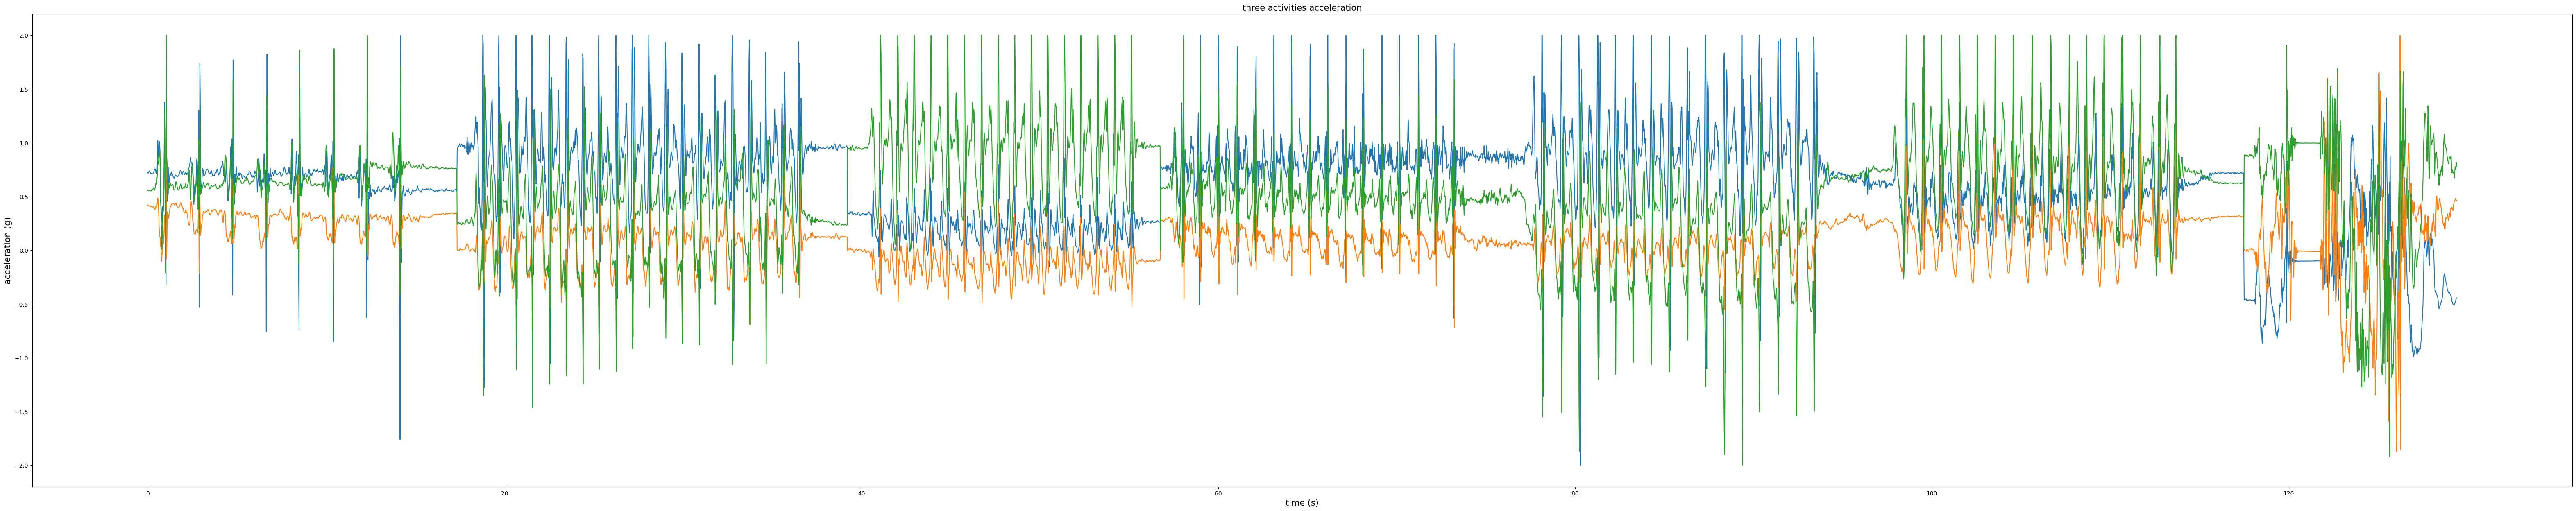

In [ ]:
fig = plt.subplots(figsize=(80, 15))

plt.title("three activities acceleration", fontsize=15)
plt.xlabel("time (s)", fontsize=15)
plt.ylabel("acceleration (g)", fontsize=15)

plt.rcParams["axes.xmargin"] = 0
plt.rcParams["axes.ymargin"] = 0.08

for col in ["x", "y", "z"]:
    plt.plot(motion_df.iloc[:, 0], motion_df[col])

### Preprocessing ???

In [ ]:
import numpy as np

In [ ]:
# Euclidean norm of samples across the 3 axes, stored in "a" for acceleration
motion_df["a"] = motion_df.loc[:, ["x", "y", "z"]].apply(np.linalg.norm, axis = 1)

motion_df["a"].head()

0    1.004352
1    0.996170
2    0.998277
3    1.005906
4    1.005957
Name: a, dtype: float64

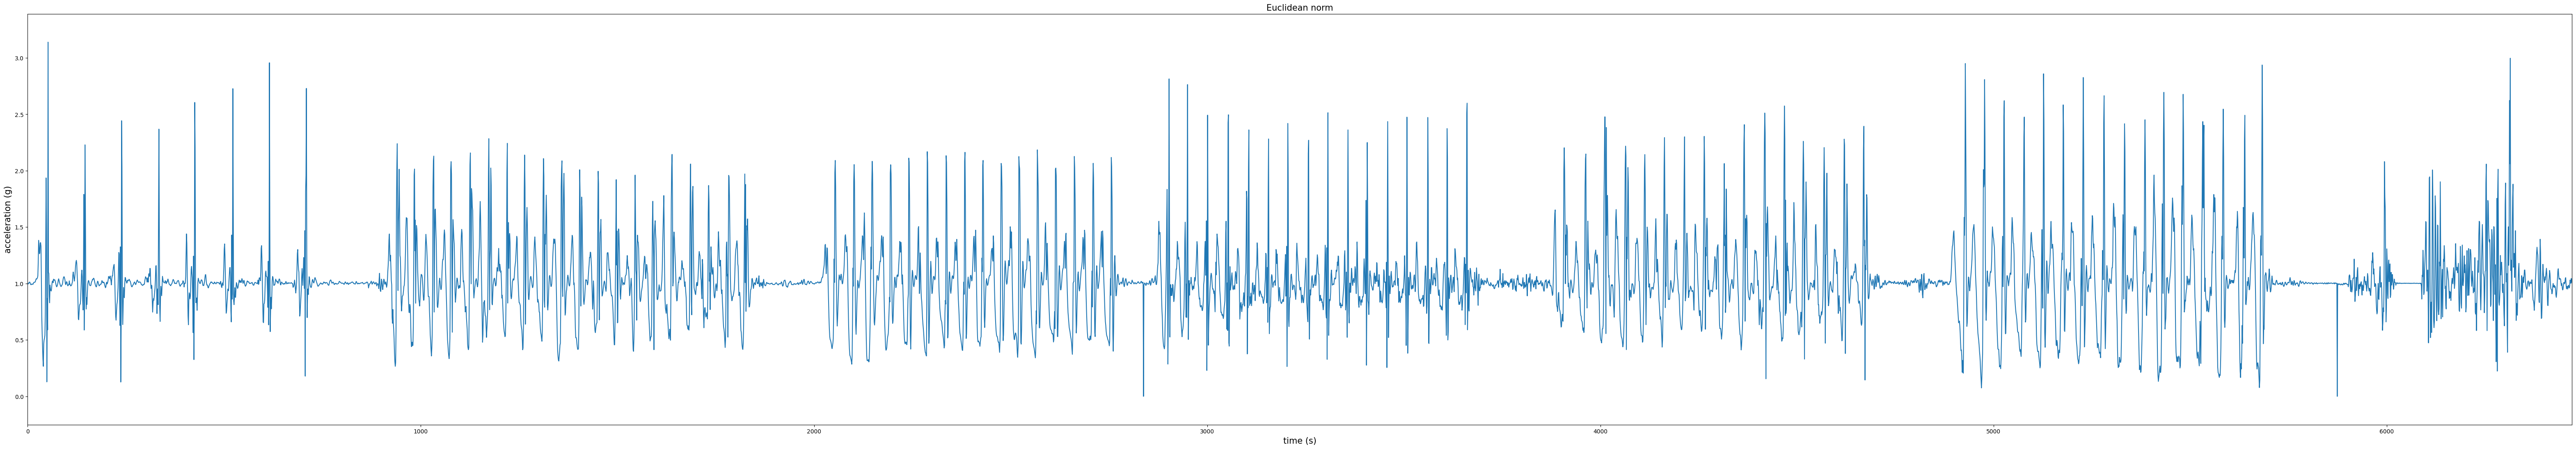

In [ ]:
# Plot of all mean values for all samples
fig = plt.subplots(figsize=(80, 13))

plt.title("Euclidean norm", fontsize=15)
plt.xlabel("time (s)", fontsize=15)
plt.ylabel("acceleration (g)", fontsize=15)

plt.plot(motion_df["a"])

In [ ]:
# Number of samples 

motion_df.shape[0]

6472

Normalized acceleration

The directional information will be lost, but it will make the main acceleraation of the three axes more "readable" and easy to understand 

In [ ]:
#Euclidean norm
motion_df["a"] = motion_df.loc[:, ["x", "y", "z"]].apply(np.linalg.norm, axis=1)

<Axes: >

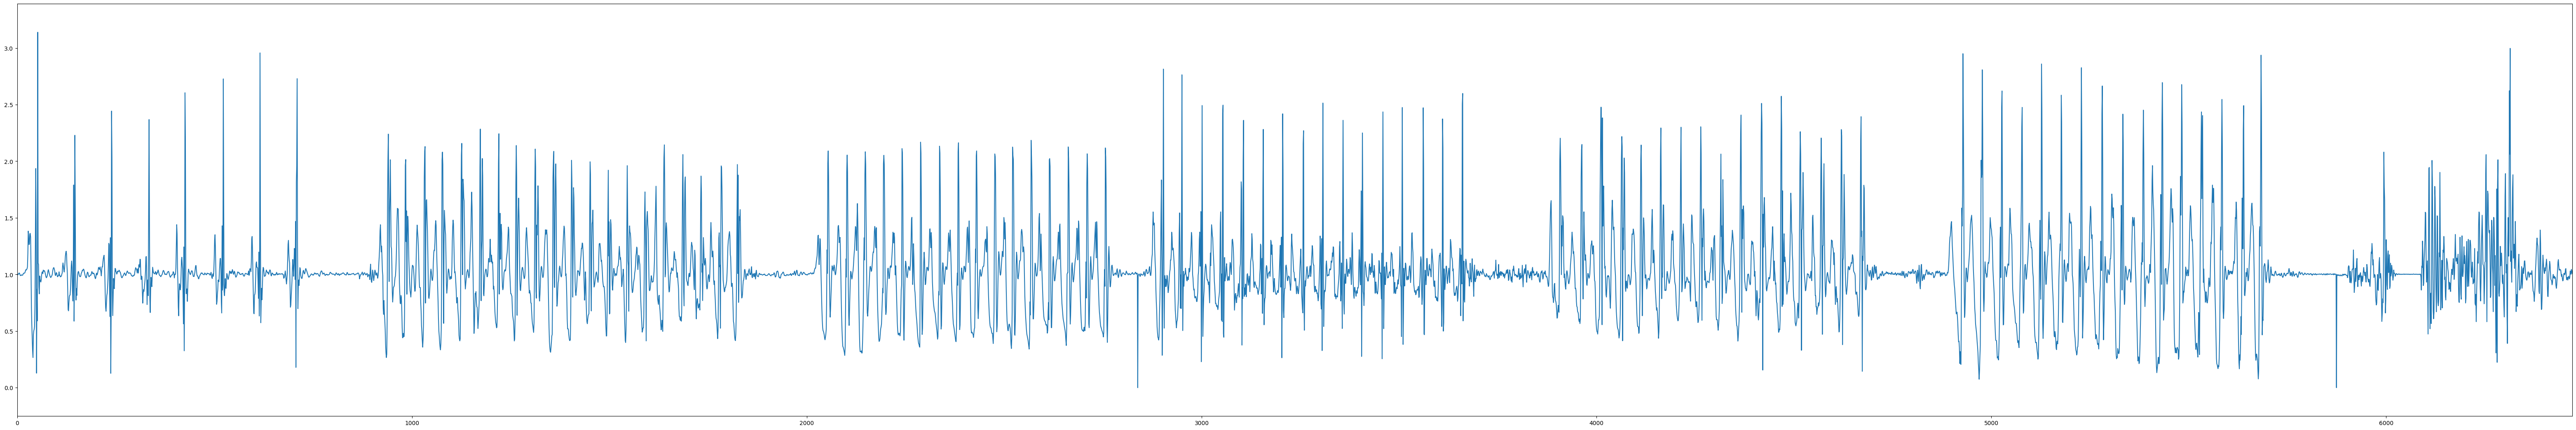

In [ ]:
motion_df["a"].plot(figsize=(80, 13))

### Sliding window

#### Creating the feature space

In [ ]:
# Window size

window = 150  # samples for every 3 seconds
# steps = range(0, len(motion_df), 10)

F = pd.DataFrame() # DatFrame for the feature space

count = 0

Statistical features to calculate the correlation between each feature and the target label 

In [ ]:
# calculate features
for x in range(0, len(motion_df), window):
    
    if (x + window) < len(motion_df):
        
        print("Range from: " + str(x) + " to " + str(x + window))
        count += 1

        # samples from x to x+window, all rows
        d = motion_df.loc[x : x + window, :]  

        #
        F.loc[count, "sample"] = x
        F.loc[count, "time"] = d.loc[x + round(window / 2), "time"]

        F.loc[count, "label"] = d.loc[x + round(window / 2), "output"]
        F.loc[count, "a_mean"] = d["a"].mean()
        F.loc[count, "a_std"] = d["a"].std()
        # zero count ... look up
        F.loc[count, "x_mean"] = d["x"].mean()
        F.loc[count, "y_mean"] = d["y"].mean()
        F.loc[count, "z_mean"] = d["z"].mean()
        
        print("Window: " + str(count))
        print("Sample x: " + str(x))

Range from: 0 to 150
Window: 1
Sample x: 0
Range from: 150 to 300
Window: 2
Sample x: 150
Range from: 300 to 450
Window: 3
Sample x: 300
Range from: 450 to 600
Window: 4
Sample x: 450
Range from: 600 to 750
Window: 5
Sample x: 600
Range from: 750 to 900
Window: 6
Sample x: 750
Range from: 900 to 1050
Window: 7
Sample x: 900
Range from: 1050 to 1200
Window: 8
Sample x: 1050
Range from: 1200 to 1350
Window: 9
Sample x: 1200
Range from: 1350 to 1500
Window: 10
Sample x: 1350
Range from: 1500 to 1650
Window: 11
Sample x: 1500
Range from: 1650 to 1800
Window: 12
Sample x: 1650
Range from: 1800 to 1950
Window: 13
Sample x: 1800
Range from: 1950 to 2100
Window: 14
Sample x: 1950
Range from: 2100 to 2250
Window: 15
Sample x: 2100
Range from: 2250 to 2400
Window: 16
Sample x: 2250
Range from: 2400 to 2550
Window: 17
Sample x: 2400
Range from: 2550 to 2700
Window: 18
Sample x: 2550
Range from: 2700 to 2850
Window: 19
Sample x: 2700
Range from: 2850 to 3000
Window: 20
Sample x: 2850
Range from: 3

In [ ]:
F

,sample,time,label,a_mean,a_std,x_mean,y_mean,z_mean
1,0.0,1.5,drum,1.010433,0.302559,0.706821,0.329629,0.603768
2,150.0,4.5,drum,1.004378,0.187032,0.705232,0.312709,0.628848
3,300.0,7.5,drum,1.018086,0.240084,0.700099,0.261550,0.648616
4,450.0,10.5,drum,1.015817,0.182708,0.692106,0.265424,0.667523
5,600.0,13.5,drum,1.029946,0.271373,0.558689,0.260404,0.772834
6,750.0,16.5,drum,1.002804,0.015287,0.650358,0.254795,0.652728
7,900.0,19.5,guitar,1.050607,0.395933,0.868563,-0.023974,0.269775
8,1050.0,22.5,guitar,1.072066,0.397435,0.875887,0.022126,0.246053
9,1200.0,25.5,guitar,1.043797,0.369182,0.838391,-0.019715,0.258377
10,1350.0,28.5,guitar,1.030115,0.384005,0.890192,-0.008675,0.201252


In [ ]:
fig = plt.subplots(figsize=(10, 5))

for col in ["a_mean", "a_std", "x_mean", "y_mean", "z_mean"]:
    plt.plot(F.loc[:, "time"], F.loc[:, col])

    
    # TODO turn the x axis scale into the time domain
    


NameError: name 'plt' is not defined